# Rate limiting in async code

This post describes three ways to rate limit async code in a way that optimizes for throughput and latency. The first two methods use native asyncio primitives, while the third uses aiochan, a third-party library that is meant to provide functionality similar to channels in Go.

## Definitions

A few definitions to set the context for this post:

- "rate limit" means to limit the number of operations per period
- "operations" is the number of times a function is called in a given period
- "period" is the time window in which the number of operations is limited

## Setup

Typically, rate limiting is used in the context of a web server. For this post, I'll use a function that returns a timestamp to mock the request to the server. I'll also have that function sleep for a random amount of time to simulate the work that the server is doing.

In [14]:
import asyncio

import httpx
import pendulum as pdl
from contextlib import asynccontextmanager
import time
import pandas as pd

In [16]:
def now():
    return int(pdl.now().format("x"))

async def server():
    return now()

In [17]:
times = []
for i in range(10):
    for i in range(10):
        start = now()
        httpx.get('http://httpbin.org/get')
        times.append(now() - start)
    time.sleep(1)

times_per_request = pd.Series(times)

<AxesSubplot: >

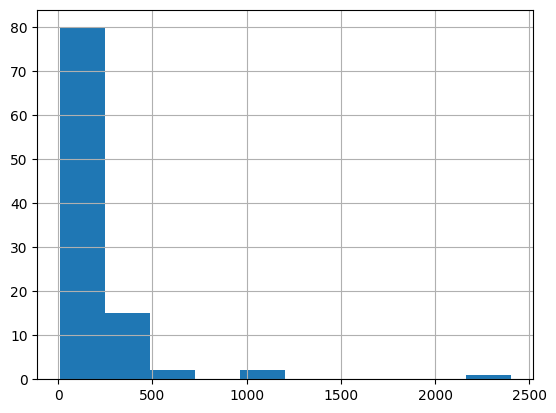

In [19]:
times_per_request.hist()

## Method 1: simple semaphore context manager

This is the simplest way to rate limit async code. It uses a semaphore to limit the number of concurrent tasks, and a context manager to ensure that the semaphore is released when the task is done. At the end of each task, the context manager sleeps for the required period before releasing the semaphore.

In [10]:

def create_simple_rate_limiter(max_requests, period):
    """Create a rate limiter that limits the number of requests to `max_requests` per `period` seconds."""
    sem =  asyncio.Semaphore(max_requests)

    @asynccontextmanager
    async def rate_limiter():
        try:
            await sem.acquire()
            yield
        finally:
            asyncio.sleep(period)
            sem.release()
    return rate_limiter

    

In [9]:
simple_limiter = create_simple_rate_limiter(5, 1)

In [ ]:
times = []
for i in range(10):
    row = [i, pdl.]
    async with simple_limiter():
        times.append(await server())